# Maximum likelihood Estimation (MLE)
## Simulate coin flipping
- [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) 
is the probability distribution of a random variable which takes the value 1 with probability $p$ and the value 0 with probability $q = 1 - p$
- [scipy.stats.bernoulli](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html)

In [1]:
from scipy.stats import bernoulli 

p_true = 1/2 # this is the value we will try to estimate from the observed data
fp = bernoulli(p_true)

def sample(n=10):
    """
    simulate coin flipping
    """
    return fp.rvs(n) # flip it n times

xs = sample(100) # generate some samples

## Find maximum of Bernoulli distribution
Single experiment
$$\phi(x) = p ^ {x} * (1 - p) ^ { 1 - x }$$
Series of experiments
$$\mathcal{L}(p|x) = \prod_{i=1}^{n} p^{x_{i}}*(p-1)^{1-x_{i}}$$
### Hints
- [sympy.diff()](http://docs.sympy.org/dev/modules/core.html#sympy.core.function.diff)
- [sympy.expand()](http://docs.sympy.org/dev/modules/core.html#sympy.core.function.expand)
- [sympy.expand_log()](http://docs.sympy.org/dev/modules/core.html#sympy.core.function.expand_log)
- [sympy.solve()](http://docs.sympy.org/dev/modules/core.html#sympy.core.function.solve)
- [sympy.symbols()](http://docs.sympy.org/dev/modules/core.html#symbols)
- [sympy gotchas](http://docs.sympy.org/dev/tutorial/gotchas.html)

In [2]:
import numpy as np
import sympy
from sympy.abc import x

p = sympy.symbols('p', positive=True)
phi = p ** x * (1 - p) ** (1 - x)
L = np.prod([phi.subs(x, i) for i in xs]) # objective function to maximize
log_L = sympy.expand_log(sympy.log(L))
sol = sympy.solve(sympy.diff(log_L, p), p)[0]

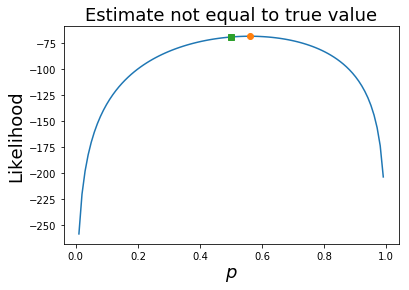

In [3]:
import matplotlib.pyplot as plt

x_space = np.linspace(1/100, 1, 100, endpoint=False)

plt.plot(x_space,
         list(map(sympy.lambdify(p, log_L, 'numpy'), x_space)),
         sol,
         log_L.subs(p,sol),
         'o',
         p_true,
         log_L.subs(p, p_true),
         's',
        )
plt.xlabel('$p$', fontsize=18)
plt.ylabel('Likelihood', fontsize=18)
plt.title('Estimate not equal to true value', fontsize=18)
plt.show()